#### Importing Libraries

In [1]:
import random
import math
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import PIL
from PIL import Image
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import UpSampling2D, Conv2D, Dense, Reshape, BatchNormalization, LeakyReLU, Dropout, ZeroPadding2D, Flatten, Activation
from tensorflow.keras.optimizers import Adam
import tqdm

import warnings
warnings.filterwarnings('ignore')

RuntimeError: module compiled against API version 0xe but this version of numpy is 0xd

In [2]:
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
gpus

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [4]:
# !nvidia-smi

In [5]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 3630135315493613766
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 5712642048
locality {
  bus_id: 1
  links {
  }
}
incarnation: 17804480719085254652
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3070 Ti Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6"
]


In [6]:
## GPU is enabled

#### Data Loading and Preprocessing

In [7]:
data_path = './Portraits_update/Portraits/'
batch_s = 64

data = tf.keras.preprocessing.image_dataset_from_directory(data_path, label_mode=None, image_size=(64,64), batch_size=batch_s)

Found 6512 files belonging to 1 classes.


In [8]:
def show_image(data):
    plt.figure(figsize=(15,15))
    for images in data.take(1):
        for i in range(18):
            ax = plt.subplot(6, 6, i+1)
            ax.imshow(images[i].numpy().astype('uint8'))

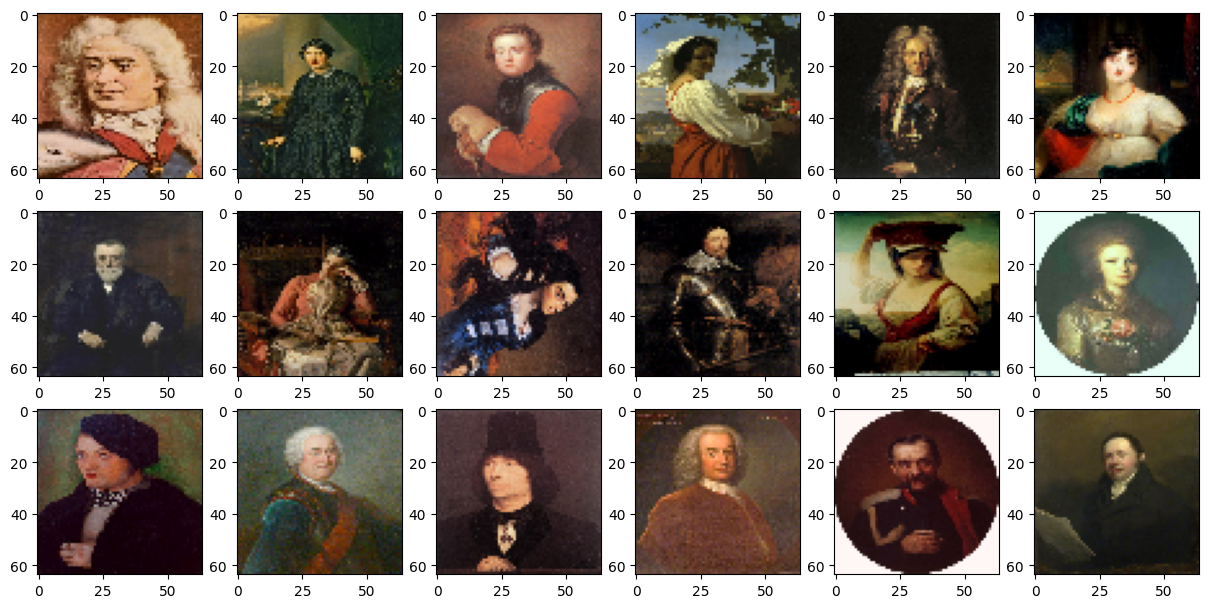

In [9]:
show_image(data)

In [10]:
## All the data between 0 and 1
data = data.map(lambda x: x/255.0)
data

<MapDataset shapes: (None, 64, 64, 3), types: tf.float32>

#### Building GAN

1. Generator

In [11]:
latent_dim = 100
g_resolution = 2

In [12]:
def build_generator():
    generator = Sequential()
    
    generator.add(Dense(4*4*256, input_dim=latent_dim))
    generator.add(Activation('relu'))
    generator.add(Reshape((4,4,256)))
    
    generator.add(UpSampling2D())
    generator.add(Conv2D(256, kernel_size=3, padding='same'))
    generator.add(BatchNormalization(momentum=0.8))
    generator.add(Activation('relu'))
    
    generator.add(UpSampling2D())
    generator.add(Conv2D(256, kernel_size=3, padding='same'))
    generator.add(BatchNormalization(momentum=0.8))
    generator.add(Activation('relu'))
    
    generator.add(UpSampling2D())
    generator.add(Conv2D(256, kernel_size=3, padding='same'))
    generator.add(BatchNormalization(momentum=0.8))
    generator.add(Activation('relu'))
    
    generator.add(UpSampling2D())
    generator.add(Conv2D(128, kernel_size=3, padding='same'))
    generator.add(BatchNormalization(momentum=0.8))
    generator.add(Activation('relu'))
    
    generator.add(Conv2D(64, kernel_size=3, padding='same'))
    generator.add(BatchNormalization(momentum=0.8))
    generator.add(Activation('relu'))
    
    generator.add(Conv2D(3, kernel_size=3, padding='same'))
    generator.add(Activation('tanh'))
    
    return generator

In [13]:
generator = build_generator()

In [14]:
generator.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 4096)              413696    
_________________________________________________________________
activation (Activation)      (None, 4096)              0         
_________________________________________________________________
reshape (Reshape)            (None, 4, 4, 256)         0         
_________________________________________________________________
up_sampling2d (UpSampling2D) (None, 8, 8, 256)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 8, 8, 256)         590080    
_________________________________________________________________
batch_normalization (BatchNo (None, 8, 8, 256)         1024      
_________________________________________________________________
activation_1 (Activation)    (None, 8, 8, 256)         0

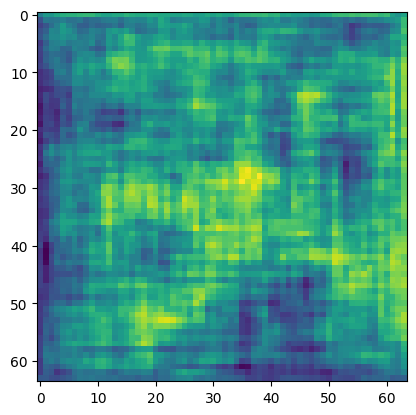

In [15]:
seed = tf.random.normal([1, latent_dim])
Generated_Protrait = generator(seed, training=False)

plt.imshow(Generated_Protrait[0, :, :, 0])

2. Discriminator

In [16]:
def build_discriminator():
    model = Sequential()
    
    model.add(Conv2D(32, kernel_size=3, strides=2, input_shape=(64, 64,3), padding='same'))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.25))
    
    model.add(Conv2D(64, kernel_size=3, strides=2, padding='same'))
    model.add(ZeroPadding2D(padding=((0,1),(0,1))))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.25))
    
    model.add(Conv2D(128, kernel_size=3, strides=2, padding='same'))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.25))
    
    model.add(Conv2D(256, kernel_size=3, strides=1, padding='same'))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.25))

    model.add(Conv2D(512, kernel_size=3, strides=1, padding='same'))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.25))
    
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))
    
    return model

In [17]:
discriminator = build_discriminator()

In [18]:
discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 32, 32, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 16, 16, 64)        18496     
_________________________________________________________________
zero_padding2d (ZeroPadding2 (None, 17, 17, 64)        0         
_________________________________________________________________
batch_normalization_5 (Batch (None, 17, 17, 64)        256       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 17, 17, 64)       

In [19]:
Discriminator_verdict = discriminator(Generated_Protrait)
print(Discriminator_verdict)

tf.Tensor([[0.49994677]], shape=(1, 1), dtype=float32)


#### GAN Compilation

In [20]:
class GAN(tf.keras.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super(GAN, self).__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim
    
    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super(GAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn
        self.d_loss_metric = tf.keras.metrics.Mean(name='d_loss')
        self.g_loss_metric = tf.keras.metrics.Mean(name='g_loss')        
    
    @property
    def metrics(self):
        return [self.d_loss_metric, self.g_loss_metric]
    
    def train_step(self, real_images):
        batch_size = tf.shape(real_images)[0]
        seed = tf.random.normal(shape=(batch_size, self.latent_dim))
        
        generated_images = self.generator(seed)
        combined_images = tf.concat([generated_images, real_images], axis=0)
        labels = tf.concat([tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))], axis=0)
        
        labels += 0.05 * tf.random.uniform(tf.shape(labels))
        
        with tf.GradientTape() as tape:
            predictions = self.discriminator(combined_images)
            d_loss = self.loss_fn(labels, predictions)
        
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(zip(grads, self.discriminator.trainable_weights))
        
        seed = tf.random.normal(shape=(batch_size, self.latent_dim))
        misleading_labels = tf.zeros((batch_size, 1))

        with tf.GradientTape() as tape:
            predictions = self.discriminator(self.generator(seed))
            g_loss = self.loss_fn(misleading_labels, predictions)
            
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))

        self.d_loss_metric.update_state(d_loss)
        self.g_loss_metric.update_state(g_loss)
        return {"d_loss": self.d_loss_metric.result(), "g_loss": self.g_loss_metric.result()}
    
    

In [21]:
## Callbacks
import os
from tensorflow.keras.preprocessing.image import array_to_img
from tensorflow.keras.callbacks import Callback

In [22]:
class ModelMonitor(Callback):
    def __init__(self, num_img=3, latent_dim=100):
        self.num_img = num_img
        self.latent_dim = latent_dim
    
    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = tf.random.uniform((self.num_img, self.latent_dim))
        generated_images = self.model.generator(random_latent_vectors)
        generated_images *= 255
        generated_images.numpy()
        for i in range(self.num_img):
            img = array_to_img(generated_images[i])
            img.save(os.path.join('images2', f'generated_img_{epoch}_{i}.png'))

#### Training the model

In [23]:
epochs = 2000

discriminator_opt = tf.keras.optimizers.Adamax(1.5e-4, 0.5)
generator_opt = tf.keras.optimizers.Adamax(1.5e-4, 0.5)
loss_fn = tf.keras.losses.BinaryCrossentropy()

model = GAN(discriminator=discriminator, generator=generator, latent_dim=latent_dim)

model.compile(d_optimizer=discriminator_opt, g_optimizer=generator_opt, loss_fn=loss_fn)

In [24]:
hist = model.fit(data, epochs=epochs, callbacks=[ModelMonitor()])

Epoch 1/2000
102/102 [==============================] - 20s 150ms/step - d_loss: 0.6695 - g_loss: 0.7512
Epoch 2/2000
102/102 [==============================] - 14s 132ms/step - d_loss: 0.6778 - g_loss: 0.8102
Epoch 3/2000
102/102 [==============================] - 14s 132ms/step - d_loss: 0.6838 - g_loss: 0.7795
Epoch 4/2000
102/102 [==============================] - 14s 132ms/step - d_loss: 0.6694 - g_loss: 0.7942
Epoch 5/2000
102/102 [==============================] - 14s 133ms/step - d_loss: 0.6581 - g_loss: 0.8278
Epoch 6/2000
102/102 [==============================] - 14s 133ms/step - d_loss: 0.6437 - g_loss: 0.8640
Epoch 7/2000
102/102 [==============================] - 14s 133ms/step - d_loss: 0.6174 - g_loss: 0.9645
Epoch 8/2000
102/102 [==============================] - 15s 135ms/step - d_loss: 0.5877 - g_loss: 1.0645
Epoch 9/2000
102/102 [==============================] - 15s 136ms/step - d_loss: 0.6060 - g_loss: 1.1357
Epoch 10/2000
102/102 [==============================] 

KeyboardInterrupt: 

#### Evaluating the model

In [ ]:
import pandas as pd

pal = ['#994F5F', '#E2AB30']
history_df = pd.DataFrame(hist.history)
fig = plt.figure(figsize=(15,4))
ax = sns.lineplot(data = history_df, palette = pal)
ax.set(xlabel='Epochs')
ax.set(ylabel='Loss')
ax.set_title('Learning Curve')

In [27]:
num_img = 18

def Potrait_Generator():
    Generated_Paintings = []
    seed = tf.random.normal([num_img, latent_dim])
    generated_image = generator(seed)
    generated_image *= 255
    generated_image = generated_image.numpy()
    for i in range(num_img):
        img = tf.keras.preprocessing.image.array_to_img(generated_image[i])
        Generated_Paintings.append(img)
        img.save(f'Generated_Images/Potraits{i}.png')
    return

In [28]:
Images = Potrait_Generator()

#### Conclusion

#### End

In [26]:
generator.save('generator_painting800.h5')
discriminator.save('discriminator_painting800.h5')

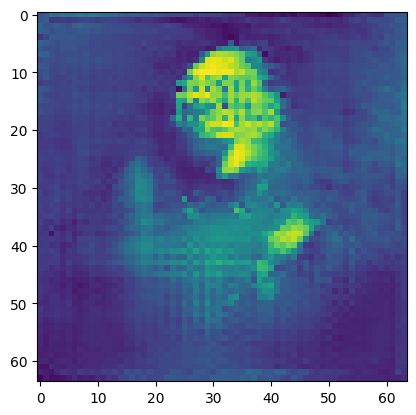

In [32]:
seed = tf.random.normal([1, latent_dim])
Generated_Protrait = generator(seed, training=False)

plt.imshow(Generated_Protrait[0, :, :, 0])

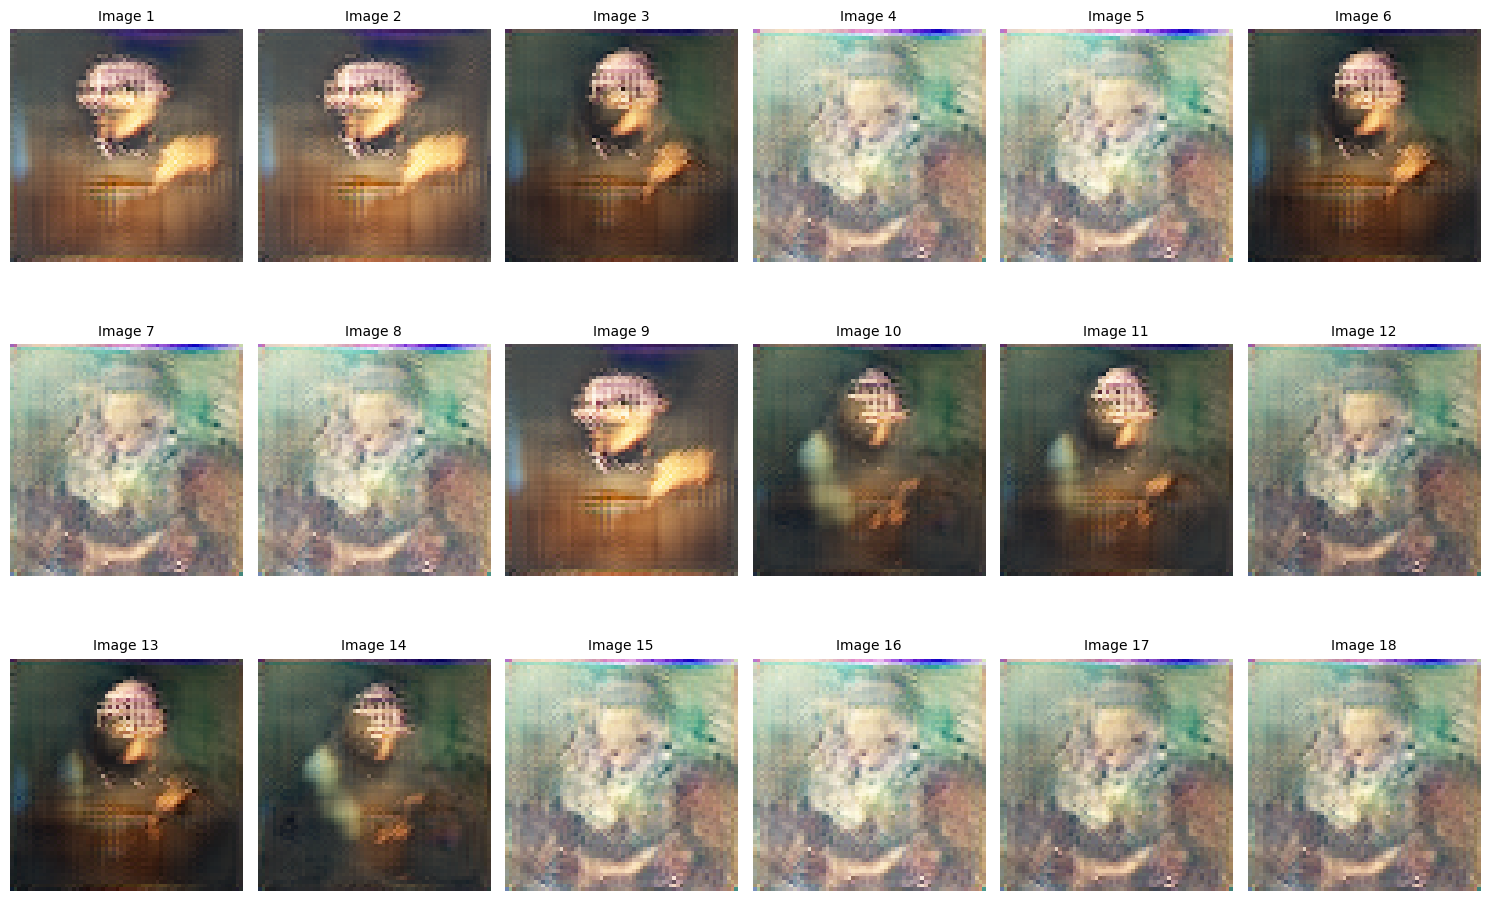

In [36]:
import os
from matplotlib import pyplot as plt
from PIL import Image

# Folder containing the images
image_folder = './Generated_Images/'

# List of image files in the folder
image_files = [f for f in os.listdir(image_folder) if f.endswith(('png'))]

# Take the first 18 images (adjust if fewer images exist)
image_files = image_files[:18]

# Number of images per row
num_columns = 6
num_rows = (len(image_files) + num_columns - 1) // num_columns

# Create a figure
plt.figure(figsize=(15, 10))

for i, image_file in enumerate(image_files):
    image_path = os.path.join(image_folder, image_file)
    image = Image.open(image_path)
    
    # Add subplot
    plt.subplot(num_rows, num_columns, i + 1)
    plt.imshow(image)
    plt.axis('off')  # Hide axes
    plt.title(f"Image {i + 1}", fontsize=10)

plt.tight_layout()
plt.show()
